In [1]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Load dataset function
def load_dataset(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for img in os.listdir(label_dir):
                images.append(os.path.join(label_dir, img))  # Full image path
                labels.append(label)  # Folder name is the label
            print(f"{label} Completed")
    return images, labels

# Load and shuffle training data
TRAIN_DIR = 'data_split/train'
train = pd.DataFrame()
train['image'], train['emotion'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True)

# Extract features from images
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale', target_size=(48, 48))  # 48x48 grayscale image
        img = np.array(img)
        features.append(img)
    
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)  # Add channel dimension for grayscale
    return features

# Normalize image data
def preprocess_images():
    train_features = extract_features(train['image'])
    x_train = train_features / 255.0

    # Label encoding
    le = LabelEncoder()
    le.fit(train['emotion'])
    y_train = le.transform(train['emotion'])
    
    return x_train, y_train, le

x_train, y_train, le = preprocess_images()

# Load and preprocess test data (you can do similar steps as for training data)
TEST_DIR = 'data_split/test'
test = pd.DataFrame()
test['image'], test['emotion'] = load_dataset(TEST_DIR)
test_features = extract_features(test['image'])
x_test = test_features / 255.0
y_test = le.transform(test['emotion'])

# Final check for shapes
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


anger Completed
contempt Completed
disgust Completed
fear Completed
happiness Completed
neutral Completed
sadness Completed
surprise Completed


100%|███████████████████████████████████████████████████████████████████████████| 10947/10947 [00:17<00:00, 609.37it/s]


anger Completed
contempt Completed
disgust Completed
fear Completed
happiness Completed
neutral Completed
sadness Completed
surprise Completed


100%|█████████████████████████████████████████████████████████████████████████████| 2738/2738 [00:03<00:00, 710.46it/s]


x_train shape: (10947, 48, 48, 1)
y_train shape: (10947,)
x_test shape: (2738, 48, 48, 1)
y_test shape: (2738,)


In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam

# Define the Inception module
def inception_module(x, filters):
    # 1x1 convolution branch
    branch1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 1x1 convolution followed by 3x3 convolution branch
    branch3x3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch3x3)

    # 1x1 convolution followed by 5x5 convolution branch
    branch5x5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    branch5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch5x5)

    # 3x3 max pooling followed by 1x1 convolution branch
    branch_pool = MaxPooling2D((3, 3), strides=1, padding='same')(x)
    branch_pool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(branch_pool)

    # Concatenate all the branches
    x = Concatenate(axis=-1)([branch1x1, branch3x3, branch5x5, branch_pool])

    return x

# Define the GoogLeNet-inspired model
def build_googlenet_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)
    x = BatchNormalization()(x)

    # Inception Modules
    x = inception_module(x, [64, 128, 128, 32, 32, 32])  # First Inception Module
    x = inception_module(x, [128, 256, 256, 64, 64, 64])  # Second Inception Module
    x = inception_module(x, [256, 512, 512, 128, 128, 128])  # Third Inception Module
    
    # Global Average Pooling
    x = AveragePooling2D(pool_size=(5, 5))(x)
    x = Flatten()(x)

    # Fully connected layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer with softmax activation for multi-class classification
    output = Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = Model(inputs, output)
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Define the input shape (48x48 grayscale images with 1 channel) and number of classes
input_shape = (48, 48, 1)
num_classes = len(le.classes_)  # The number of unique emotions

# Create the GoogLeNet-inspired model
model = build_googlenet_model(input_shape, num_classes)

# Print the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 48, 48, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 24, 24, 64)        │           3,200 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 11, 11, 64)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 11, 11, 64)        │             256 │ max_pooling2d[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 11, 11, 128)       │           8,320 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 11, 11, 32)        │           2,080 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 11, 11, 64)        │               0 │ batch_normalization[0][0]  │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 11, 11, 64)        │           4,160 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 11, 11, 128)       │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 11, 11, 32)        │          25,632 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 11, 11, 32)        │           2,080 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 11, 11, 256)       │               0 │ conv2d_1[0][0],            │
│                               │                           │                 │ conv2d_3[0][0],            │
│                               │                           │                 │ conv2d_5[0][0],            │
│                               │                           │                 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 11, 11, 256)       │          65,792 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 11, 11, 64)        │          16,448 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 11, 11, 256)       │               

 Total params: 9,565,416 (36.49 MB)

 Trainable params: 9,565,288 (36.49 MB)

 Non-trainable params: 128 (512.00 B)

In [7]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 292s 821ms/step - accuracy: 0.4755 - loss: 1.1522 - val_accuracy: 0.5015 - val_loss: 1.1047
Epoch 2/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 339s 869ms/step - accuracy: 0.5571 - loss: 0.9834 - val_accuracy: 0.7363 - val_loss: 0.8370
Epoch 3/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 297s 867ms/step - accuracy: 0.7973 - loss: 0.6332 - val_accuracy: 0.8020 - val_loss: 0.6561
Epoch 4/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 435s 1s/step - accuracy: 0.8195 - loss: 0.5736 - val_accuracy: 0.8126 - val_loss: 0.6017
Epoch 5/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 296s 862ms/step - accuracy: 0.8438 - loss: 0.4987 - val_accuracy: 0.7977 - val_loss: 0.6361


In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 263ms/step - accuracy: 0.7733 - loss: 0.7098
Test Loss: 0.636064887046814
Test Accuracy: 0.7976625561714172


In [9]:
# Save the trained model
model.save('emotion_recognition_googlenet_model.keras')


Original Output: happiness
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
Predicted Output: happiness


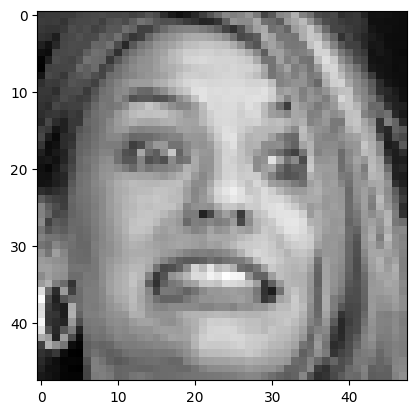

In [10]:
import random
import matplotlib.pyplot as plt
image_index = random.randint(0, len(test))
print("Original Output:", test['emotion'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted Output: neutral


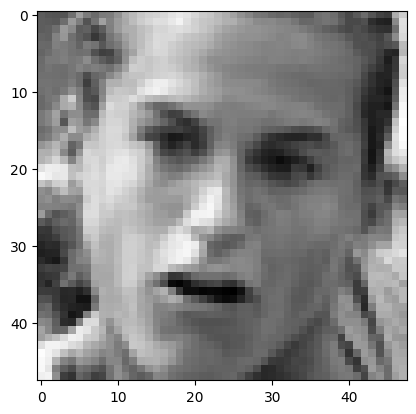

In [25]:
import random
import matplotlib.pyplot as plt
image_index = random.randint(0, len(test))
print("Original Output:", test['emotion'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: happiness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Predicted Output: happiness


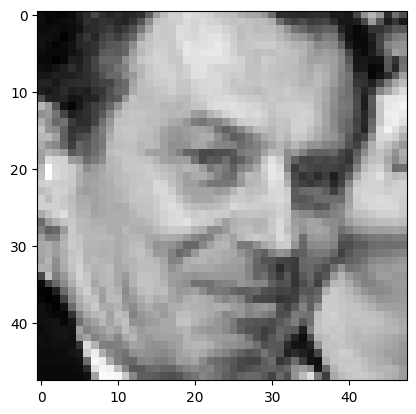

In [12]:
import random
import matplotlib.pyplot as plt
image_index = random.randint(0, len(test))
print("Original Output:", test['emotion'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: happiness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predicted Output: happiness


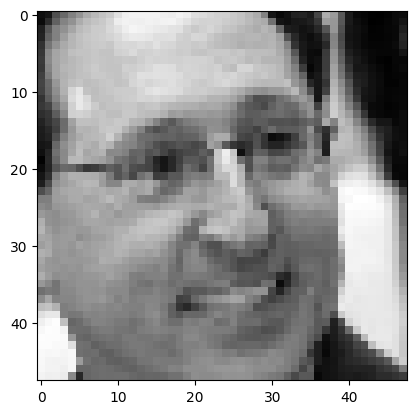

In [30]:
import random
import matplotlib.pyplot as plt
image_index = random.randint(0, len(test))
print("Original Output:", test['emotion'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');